This file is associated with Lecture 17

# Decoding Analysis using EEG Data

## Loading Data and Packages

In [1]:
# Let's load some packages we need
import mne
import mne.viz
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import copy
#Load Dataset
subject = 1 # use data from subject 1
runs = [6, 10, 14] # use only hand and feet motor imagery runs
#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)
raw_data = raw_obj._data
#Set Standard Channel Locations
eegbci.standardize(raw_obj) # set channel names
montage = make_standard_montage('standard_1005')
raw_obj.set_montage(montage)
#Extract events from raw data
events, event_ids = mne.events_from_annotations(raw_obj, event_id='auto')
tmin, tmax = -1, 4 # define epochs around events (in s)
#event_ids = dict(hands=2, feet=3) # map event IDs to tasks
epochs = mne.Epochs(raw_obj, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)
# Get sammpling frequency
fs=raw_obj.info['sfreq']

Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
90 ma

## Data Preparation

In [2]:
# Extract Data and Labels
EEG_data=epochs._data #(events, channels, samples)
Labels=epochs.events # (onset, value before event, event id)
print(np.shape(EEG_data))
print(np.shape(Labels))
print(Labels)
# Change Dimension of Data for ML Algorithm
X_all=np.mean(EEG_data,axis=1)
Y_all=Labels[:,2]
X_all=sp.stats.zscore(X_all,axis=1)
print(np.shape(X_all))
print(np.shape(Y_all))
print(Y_all)
# Remove Label 1 as it corresponds to resting state
idx=np.where(Y_all!=1)
X=X_all[idx]
Y=Y_all[idx]
print(np.shape(X))
print(np.shape(Y))
print(Y)

(87, 64, 961)
(87, 3)
[[  672     0     3]
 [ 1328     0     1]
 [ 2000     0     2]
 [ 2656     0     1]
 [ 3328     0     2]
 [ 3984     0     1]
 [ 4656     0     3]
 [ 5312     0     1]
 [ 5984     0     2]
 [ 6640     0     1]
 [ 7312     0     3]
 [ 7968     0     1]
 [ 8640     0     3]
 [ 9296     0     1]
 [ 9968     0     2]
 [10624     0     1]
 [11296     0     2]
 [11952     0     1]
 [12624     0     3]
 [13280     0     1]
 [13952     0     3]
 [14608     0     1]
 [15280     0     2]
 [15936     0     1]
 [16608     0     2]
 [17264     0     1]
 [17936     0     3]
 [18592     0     1]
 [19264     0     3]
 [20672     0     2]
 [21328     0     1]
 [22000     0     3]
 [22656     0     1]
 [23328     0     3]
 [23984     0     1]
 [24656     0     2]
 [25312     0     1]
 [25984     0     3]
 [26640     0     1]
 [27312     0     2]
 [27968     0     1]
 [28640     0     2]
 [29296     0     1]
 [29968     0     3]
 [30624     0     1]
 [31296     0     3]
 [31952     

## Training the Model

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(solver='lbfgs')
clf.fit(X, Y)
preds = clf.predict(X)
print("Predictions for samples in Y:\n", preds)
probas = clf.predict_proba(X)
acc = accuracy_score(Y, preds)
print("Accuracy:", acc)

Predictions for samples in Y:
 [3 2 2 3 2 3 3 2 2 3 3 2 2 3 3 2 3 3 2 3 2 2 3 3 2 2 3 3 2 3 3 2 3 2 2 3 2
 3 2 3 3 2 3 2 3]
Accuracy: 1.0


## Model Validation

In [6]:
# The code X[0::2, :] is a slice notation that returns a new array that is a copy of the original array, but with only every other row included.
# The first number in the slice notation, 0, is the start index, and the second number, 2, is the step size
X_train = X[0::2, :] # all even samples
Y_train = Y[0::2]
X_test = X[1::2, :] # all odd samples
Y_test = Y[1::2]
X_train_norm = sp.stats.zscore(X_train,axis=1)
clf.fit(X_train_norm, Y_train)
X_test_norm = sp.stats.zscore(X_test,axis=1)
preds = clf.predict(X_test_norm)
print("Predictions for our test set samples:\n", preds)
acc = accuracy_score(Y_test, preds)
print("Accuracy:", acc)

Predictions for our test set samples:
 [2 2 3 2 3 2 3 3 3 3 2 2 2 3 3 2 2 2 3 3 2 2]
Accuracy: 0.8181818181818182


## Model Validation Continued

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
skf = StratifiedKFold(n_splits=5)
folds = skf.split(X, Y)
train_idxs=[]
test_idxs=[]
acc_cv=[]
for i, fold in enumerate(folds):
    print("Processing fold %i" % (i + 1))
    # Here, we unpack fold (a tuple) to get the train and test indices
    train_idx, test_idx = fold
    train_idxs.append(train_idx)
    test_idxs.append(test_idx)
    print("Train indices:", train_idx)
    print("Test indices:", test_idx, end='\n\n')
acc_cv=[]
for i in range(5):
    X_train = X[train_idxs[i][:]]
    Y_train = Y[train_idxs[i][:]]
    X_test = X[test_idxs[i][:]]
    Y_test = Y[test_idxs[i][:]]
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    clf.fit(X_train_norm, Y_train)
    preds = clf.predict(X_test_norm)
    acc_cv.append(accuracy_score(Y_test, preds))
print("Accuracy Vector:" + str(acc_cv))
print("Average Accuracy:"+ str(np.mean(acc_cv)))

Processing fold 1
Train indices: [ 8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [0 1 2 3 4 5 6 7 9]

Processing fold 2
Train indices: [ 0  1  2  3  4  5  6  7  9 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [ 8 10 11 12 13 14 15 16 17]

Processing fold 3
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 25 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [18 19 20 21 22 23 24 26 27]

Processing fold 4
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 34 36 38 39 40 41 42 43 44]
Test indices: [25 28 29 30 31 32 33 35 37]

Processing fold 5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 35 37]
Test indices: [34 36 38 39 40 41 42 43 44]

Accuracy Vector:[0.8888888888888888, 0.7777777777777778, 0.5555555555

## Model Diagnosis

(array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

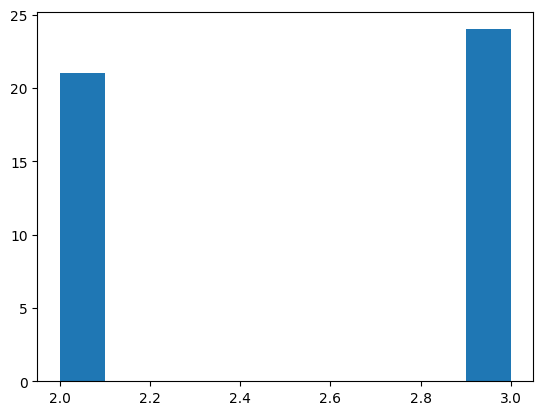

In [9]:
plt.hist(Y)

## Model Validation with ROC

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
skf = StratifiedKFold(n_splits=5)
folds = skf.split(X, Y)
train_idxs=[]
test_idxs=[]
auc_cv=[]
for i, fold in enumerate(folds):
    print("Processing fold %i" % (i + 1))
    train_idx, test_idx = fold
    train_idxs.append(train_idx)
    test_idxs.append(test_idx)
    print("Train indices:", train_idx)
    print("Test indices:", test_idx, end='\n\n')
acc_cv=[]
for i in range(5):
    X_train = X[train_idxs[i][:]] # all even samples
    Y_train = Y[train_idxs[i][:]]
    X_test = X[test_idxs[i][:]] # all odd samples
    Y_test = Y[test_idxs[i][:]]
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    clf.fit(X_train_norm, Y_train)
    preds = clf.predict(X_test_norm)
    auc_cv.append(roc_auc_score(Y_test, preds))
print("Accuracy Vector:" + str(auc_cv))
print("Average Accuracy:"+ str(np.mean(auc_cv)))

Processing fold 1
Train indices: [ 8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [0 1 2 3 4 5 6 7 9]

Processing fold 2
Train indices: [ 0  1  2  3  4  5  6  7  9 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [ 8 10 11 12 13 14 15 16 17]

Processing fold 3
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 25 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [18 19 20 21 22 23 24 26 27]

Processing fold 4
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 34 36 38 39 40 41 42 43 44]
Test indices: [25 28 29 30 31 32 33 35 37]

Processing fold 5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 35 37]
Test indices: [34 36 38 39 40 41 42 43 44]

Accuracy Vector:[0.875, 0.775, 0.55, 0.7, 0.7]
Average Accuracy:0.720

Model is not aware that there is a class imbalance, this needs to change. ^ 

## Model Diagnosis with ROC

In [11]:
clf = LogisticRegression(solver='lbfgs', class_weight='balanced')
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
skf = StratifiedKFold(n_splits=5)
folds = skf.split(X, Y)
train_idxs=[]
test_idxs=[]
auc_cv=[]
for i, fold in enumerate(folds):
    print("Processing fold %i" % (i + 1))
    train_idx, test_idx = fold
    train_idxs.append(train_idx)
    test_idxs.append(test_idx)
    print("Train indices:", train_idx)
    print("Test indices:", test_idx, end='\n\n')
acc_cv=[]
for i in range(5):
    X_train = X[train_idxs[i][:]] # all even samples
    Y_train = Y[train_idxs[i][:]]
    X_test = X[test_idxs[i][:]] # all odd samples
    Y_test = Y[test_idxs[i][:]]
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    clf.fit(X_train_norm, Y_train)
    preds = clf.predict(X_test_norm)
    auc_cv.append(roc_auc_score(Y_test, preds))
print("Accuracy Vector:" + str(auc_cv))
print("Average Accuracy:"+ str(np.mean(auc_cv)))

Processing fold 1
Train indices: [ 8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [0 1 2 3 4 5 6 7 9]

Processing fold 2
Train indices: [ 0  1  2  3  4  5  6  7  9 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [ 8 10 11 12 13 14 15 16 17]

Processing fold 3
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 25 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44]
Test indices: [18 19 20 21 22 23 24 26 27]

Processing fold 4
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 34 36 38 39 40 41 42 43 44]
Test indices: [25 28 29 30 31 32 33 35 37]

Processing fold 5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 35 37]
Test indices: [34 36 38 39 40 41 42 43 44]

Accuracy Vector:[0.875, 0.775, 0.55, 0.7, 0.7]
Average Accuracy:0.720

Data was already balanced which is why the accuracy metric is not different. ^

## Putting Everything Together

In [14]:
## Feature Extraction
EEG_freq_data=epochs.compute_psd() #(events, channels, frequencies)
X_all=np.mean(EEG_freq_data,axis=1)
Y_all=Labels[:,2]
X_all=sp.stats.zscore(X_all,axis=1)
idx=np.where(Y_all!=1)
X=X_all[idx]
Y=Y_all[idx]
## Feature Transformation
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
acc_cv=[]
for i in range(5):
    X_train = X[train_idxs[i][:]] # all even samples
    Y_train = Y[train_idxs[i][:]]
    X_test = X[test_idxs[i][:]] # all odd samples
    Y_test = Y[test_idxs[i][:]]
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    X_train_norm_PCA=pca.fit_transform(X_train_norm)
    X_test_norm_PCA = pca.transform(X_test_norm)
    #print(pca.explained_variance_)
    clf.fit(X_train_norm_PCA, Y_train)
    preds = clf.predict(X_test_norm_PCA)
    acc_cv.append(accuracy_score(Y_test, preds))
print("Accuracy Vector:" + str(acc_cv))
print("Average Accuracy:"+ str(np.mean(acc_cv)))

    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy Vector:[0.7777777777777778, 0.7777777777777778, 0.2222222222222222, 0.5555555555555556, 0.6666666666666666]
Average Accuracy:0.5999999999999999


The feature extraction must be problem specific (you might need to extract sertain features) because otherwise the evaluation metric could be substantially worse as seen above.